# Preliminaries

In [91]:

import pyprob
import numpy as np
import ot
import torch
import cProfile
import pickle

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo
from torch.utils.data import DataLoader
from pyprob.nn.dataset import OnlineDataset
from pyprob.util import InferenceEngine
from pyprob.util import to_tensor
from pyprob import Model
from pyprob.model import Parallel_Generator
import math
from pyprob.distributions import Normal
from pyprob.distributions.delta import Delta


import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

from sbi import utils
from sbi import analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


import sklearn as skl
from sklearn.linear_model import LinearRegression

from geomloss import SamplesLoss
sinkhorn = SamplesLoss(loss="sinkhorn", p=1, blur=.05)
def sinkhorn_t(x,y):
    x = torch.as_tensor(x)
    y = torch.as_tensor(y)
    return sinkhorn(x,y)

def euclidean_major(x,y):
    x = torch.as_tensor(x, dtype=torch.float32).sort()[0]
    y = torch.as_tensor(y, dtype=torch.float32).sort()[0]
    return torch.linalg.norm(x-y)

# def ot_dist(x,y):
#     # x = to_tensor(x)
#     # y = torch.stack(y)
#     x = np.array(x)
#     y = np.array(torch.stack(y))
#     a = ot.unif(len(x))
#     b = ot.unif(len(y))
#     Mat = ot.dist(x, y, metric='euclidean')
#     #Mat1 /= Mat1.max()
#     distance = to_tensor(ot.emd2(a,b,Mat))
#     return distance



# Prepare Simulator

In [92]:
QCD_mass = to_tensor(30.)
#rate=to_tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
jetdir = to_tensor([1.,1.,1.])
jetP = to_tensor(400.)
jetvec = jetP * jetdir / torch.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# Actual parameters
pt_min = to_tensor(0.3**2)
M2start = to_tensor(QCD_mass**2)
jetM = torch.sqrt(M2start) ## Mass of initial jet
jet4vec = torch.cat((torch.sqrt(jetP**2 + jetM**2).reshape(-1), jetvec))
minLeaves = 1
maxLeaves = 10000 # unachievable, to prevent rejections
maxNTry = 100


simulator = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True)



In [93]:
true_params = torch.tensor([3,3])
synthetic_data = simulator(torch.tensor([3,3]))
synthetic_obs = synthetic_data['leaves']

In [94]:
def simulation_wrapper(data):
    """
    Uses euclidean distances from a given observation as summary
    """
    def parameter_wrapper(params):
        current_obs = simulator(params)['leaves']
        if current_obs.isnan().any():
            distance = np.inf
        else:
            distance = sinkhorn_t(data, current_obs)
        return torch.as_tensor([distance])
    
    return parameter_wrapper

In [95]:
prior_min = [1e-3,1e-3]
prior_max = [10.,10]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

# Simulate

In [6]:
posterior = infer(simulation_wrapper(synthetic_obs), prior, method='SNPE', 
                  num_simulations=1000, num_workers=4)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 261 epochs.

# Plot

In [7]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

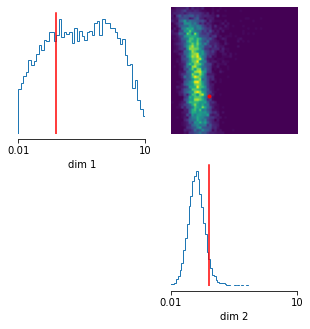

In [8]:
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array([3.,3.]),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

# Multiple rounds

In [11]:
multi_simulator, prior = prepare_for_sbi(simulation_wrapper(synthetic_obs), prior)
inference = SNPE(prior=prior)

In [12]:
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0])
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=500)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 35 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 67 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 405 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 49 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9996 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


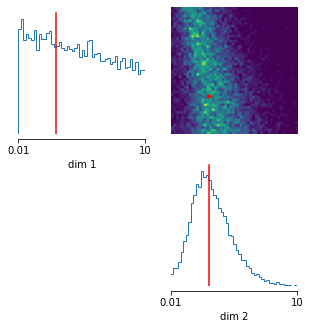

In [13]:
samples = posteriors[4].sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=np.array([3.,3.]),
                           points_offdiag={'markersize': 6},
                           points_colors='r');

# Second set of parameters

In [15]:
true_params2 = torch.tensor([5,9.5])
synthetic_data2 = simulator(true_params2)
synthetic_obs2 = synthetic_data2['leaves']

In [14]:
posterior = infer(simulation_wrapper(synthetic_obs2), prior, method='SNPE', 
                num_simulations=1000, num_workers=4)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 78 epochs.

In [15]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

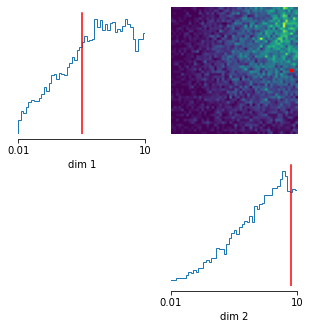

In [16]:
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params2,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [17]:
multi_simulator, prior = prepare_for_sbi(simulation_wrapper(synthetic_obs2), prior)
inference = SNPE(prior=prior)
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0])
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=500)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 72 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 44 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

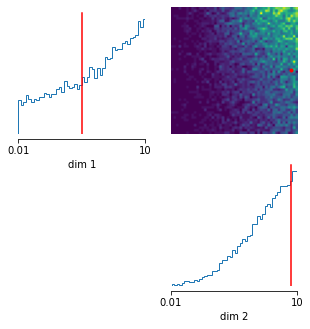

In [18]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params2,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

### Long training

In [19]:
multi_simulator, prior = prepare_for_sbi(simulation_wrapper(synthetic_obs2), prior)
inference = SNPE(prior=prior)
num_rounds = 20
posteriors = []
proposal = prior
x_o = torch.tensor([0])
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=500)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 79 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 59 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 59 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

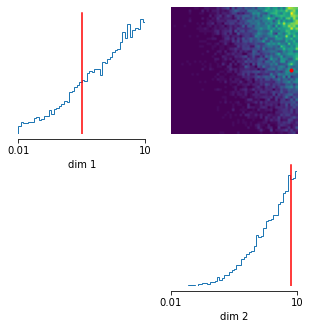

In [21]:
samples = posteriors[-1].sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params2,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

# IID Experiments

In [129]:
def simulation_wrapper_iid(data):
    """
    Uses euclidean distances from a given observation as summary
    """
    def parameter_wrapper(params):
        distances = []
        current_obs = simulator(params)['leaves']
        for obs in data:
            if current_obs.isnan().any():
                distance = np.inf
            else:
                distance = sinkhorn_t(obs, current_obs)
            distances.append(distance)
        return torch.as_tensor(distances)
    
    return parameter_wrapper

In [8]:
synthetic_data_multi = [simulator(true_params) for i in range(20)]
synthetic_obs_multi = [data['leaves'] for data in synthetic_data_multi]

In [9]:
simulation_wrapper_iid(synthetic_obs_multi)([3,3])

tensor([ 4.4745,  2.4398,  6.3847,  4.0546,  7.7825,  6.5165,  5.4368,  7.0895,
         2.8974, 11.0594,  5.0456,  4.6664,  8.0721, 19.6556,  4.5755,  9.3442,
         6.1597, 18.2445,  3.4660,  5.4421])

In [10]:
posterior = infer(simulation_wrapper_iid(synthetic_obs_multi), prior, method='SNPE', 
                  num_simulations=800, num_workers=4)

Running 800 simulations in 800 batches.:   0%|          | 0/800 [00:00<?, ?it/s]

 Neural network successfully converged after 50 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

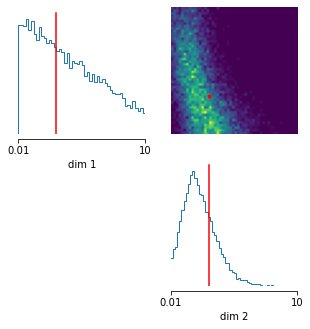

In [11]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]*20))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [16]:
multi_simulator, prior = prepare_for_sbi(simulation_wrapper_iid(synthetic_obs_multi), prior)
inference = SNPE(prior=prior)
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0]*20)
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=500, num_workers=4)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 57 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

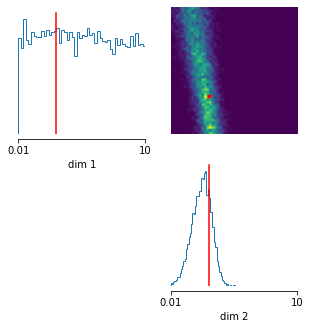

In [14]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]*20))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [ ]:
synthetic_data_multi = [simulator(true_params2) for i in range(20)]
synthetic_obs_multi = [data['leaves'] for data in synthetic_data_multi]
multi_simulator, prior = prepare_for_sbi(simulation_wrapper_iid(synthetic_obs_multi), prior)
inference = SNPE(prior=prior)
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0]*20)
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=500, num_workers=4)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

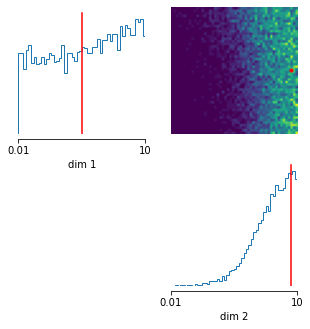

In [18]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]*20))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params2,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [96]:
def simulation_wrapper_iid_sum(data):
    """
    Uses euclidean distances from a given observation as summary
    """
    def parameter_wrapper(params):
        distances = []
        current_obs = simulator(params)['leaves']
        for obs in data:
            if current_obs.isnan().any():
                distance = np.inf
            else:
                distance = sinkhorn_t(obs, current_obs)
            distances.append(distance)
        return torch.as_tensor([sum(distances)])
    
    return parameter_wrapper

In [108]:
synthetic_obs_multi = [simulator(true_params)['leaves'] for i in range(20)]

In [109]:
posterior = infer(simulation_wrapper_iid_sum(synthetic_obs_multi), prior, method='SNPE', 
                  num_simulations=1000, num_workers=4)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 120 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

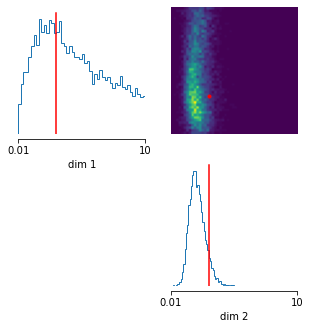

In [110]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [113]:
# Suppose we compare an experiment with existing runs to get idea of distances
x_o_sampled = simulation_wrapper_iid_sum(synthetic_obs_multi)(true_params)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

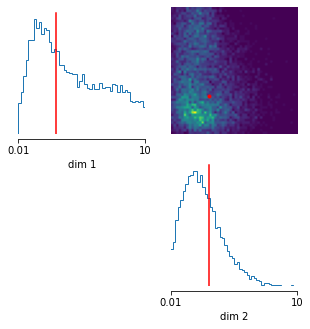

In [114]:
samples = posterior.sample((10000,), 
                           x=x_o_sampled)
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [115]:
multi_simulator, prior = prepare_for_sbi(simulation_wrapper_iid_sum(synthetic_obs_multi), prior)
inference = SNPE(prior=prior)
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0])
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=500, num_workers=4)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 148 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 56 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

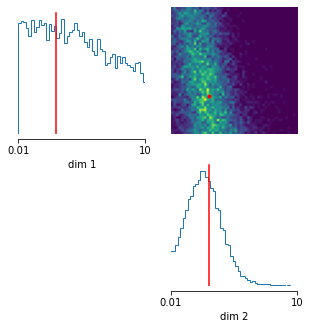

In [116]:
samples = posteriors[-1].sample((10000,), 
                           x=x_o_sampled)
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [117]:
synthetic_obs_multi = [simulator(true_params)['leaves'] for i in range(50)]

In [118]:
multi_simulator, prior = prepare_for_sbi(simulation_wrapper_iid_sum(synthetic_obs_multi), prior)
inference = SNPE(prior=prior)
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0])
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=500, num_workers=4)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 128 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9807 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


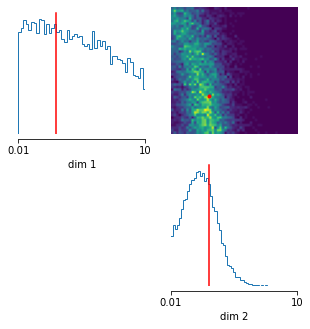

In [119]:
samples = posteriors[-1].sample((10000,), 
                           x=torch.tensor([0]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

# Fixing dim2

In [42]:
prior_min = [1e-2]
prior_max = [10.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

In [43]:
torch.cat([prior.sample(), torch.tensor([3])])

tensor([5.4061, 3.0000])

In [44]:
def simulation_wrapper_dim1(data):
    """
    Uses euclidean distances from a given observation as summary
    """
    def parameter_wrapper(param):
        distances = []
        for obs in data:
            current_obs = simulator(torch.cat([param,torch.tensor([3])]))['leaves']
            if current_obs.isnan().any():
                distance = np.inf
            else:
                distance = sinkhorn_t(obs, current_obs)
            distances.append(distance)
        return torch.as_tensor(distances)
    
    return parameter_wrapper

In [45]:
simulation_wrapper_dim1(synthetic_obs_multi)(torch.tensor([3]))

tensor([ 9.5859,  4.4544,  5.1824,  5.4468,  6.9128, 11.2220,  7.6886,  4.3490,
         8.3393,  2.6660,  9.9198,  2.3905, 10.2841,  3.5237,  4.2211,  2.7713,
         3.8696,  9.8700,  6.0604,  4.8583])

In [46]:
true_dim1 = 3
synthetic_data_multi = [simulator([true_dim1,3]) for i in range(20)]
synthetic_obs_multi = [data['leaves'] for data in synthetic_data_multi]

In [48]:
multi_simulator, prior = prepare_for_sbi(simulation_wrapper_dim1(synthetic_obs_multi), prior)
inference = SNPE(prior=prior)
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0]*20)
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=500, num_workers=4)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/sragy/anaconda3/lib/python3.8/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 27 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

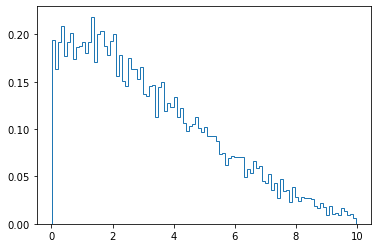

In [55]:
samples = posteriors[-1].sample((10000,), 
                           x=torch.tensor([0]*20))

plt.hist(samples.detach().numpy(),bins=100, histtype=u'step', density=True)
plt.show()

In [56]:
true_dim1 = 8
synthetic_data_multi = [simulator([true_dim1,3]) for i in range(20)]
synthetic_obs_multi = [data['leaves'] for data in synthetic_data_multi]
multi_simulator, prior = prepare_for_sbi(simulation_wrapper_dim1(synthetic_obs_multi), prior)
inference = SNPE(prior=prior)
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0]*20)
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=500, num_workers=4)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/sragy/anaconda3/lib/python3.8/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 59 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

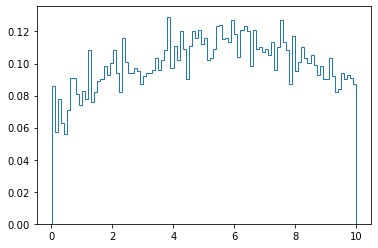

In [57]:
samples = posteriors[-1].sample((10000,), 
                           x=torch.tensor([0]*20))

plt.hist(samples.detach().numpy(),bins=100, histtype=u'step', density=True)
plt.show()

# Distance plus summaries

In [47]:
def summaries(leaves, reference_obs):

    leaf_count = torch.as_tensor(len(leaves))
    energy_variance = torch.as_tensor(leaves[:,0].var())
    if leaves.isnan().any():
        distance = torch.as_tensor(np.inf)
    else:
        distance = torch.as_tensor(sinkhorn_t(leaves, reference_obs))
  

    all_summs = torch.tensor([leaf_count, energy_variance, distance])

    return all_summs

In [48]:
def all_sums_wrapper(data):
    """
    Produces a wrapper for a function returning summaries.
    """
    def parameter_wrapper(params):
        leaves = simulator(params)['leaves']
        return summaries(leaves, data)

    return parameter_wrapper

In [8]:
true_params = torch.tensor([3,3])
synthetic_data = simulator(torch.tensor([3,3]))
synthetic_obs = synthetic_data['leaves']
x_o=summaries(synthetic_obs, synthetic_obs)

In [10]:
posterior = infer(all_sums_wrapper(synthetic_obs), prior, method='SNPE', 
                  num_simulations=1000, num_workers=4)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 67 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

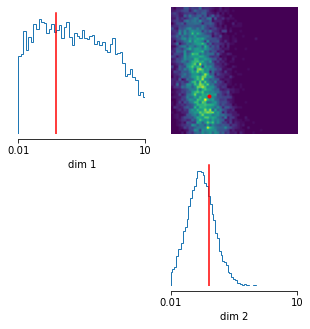

In [11]:
samples = posterior.sample((10000,), 
                           x=x_o)
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 102 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

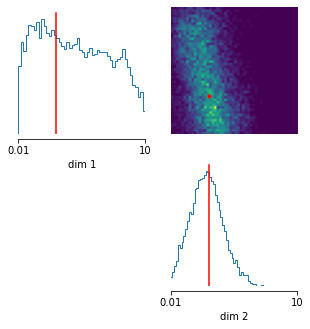

In [15]:
posterior = infer(all_sums_wrapper(synthetic_obs), prior, method='SNPE', 
                  num_simulations=5000, num_workers=4)
samples = posterior.sample((10000,), 
                           x=x_o)
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [49]:
true_params = torch.tensor([3,3])
synthetic_data = simulator(true_params)
synthetic_obs = synthetic_data['leaves']
x_o=summaries(synthetic_obs, synthetic_obs)
multi_simulator, prior = prepare_for_sbi(all_sums_wrapper(synthetic_obs), prior)
inference = SNPE(prior=prior)
num_rounds = 10
posteriors = []
proposal = prior
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=500)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 106 epochs.al network. Epochs trained: 9

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 85 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

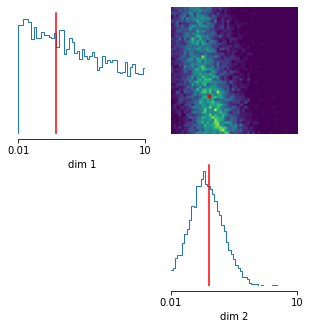

In [51]:
samples = posteriors[-1].sample((10000,), 
                           x=x_o)
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

# Distance summaries iid

In [88]:
# def summaries(data, reference_obs):

#     leaf_counts = []
#     energy_variances = []
#     distances = []

#     for leaves in data:
#         leaf_counts.append(len(leaves))
#         energy_variances.append(leaves[:,0].var())
#         if leaves.isnan().any():
#             distance = np.inf
#         else:
#             distance = sinkhorn_t(leaves, reference_obs)
#         distances.append(distance)
    
#     leaf_counts = torch.as_tensor(leaf_counts)
#     energy_variances = torch.as_tensor(energy_variances)
#     distances = torch.as_tensor(distances)

#     all_summs = torch.cat([leaf_counts, energy_variances, distances])

#     return all_summs  

# def summaries(data, reference_obs):

#     leaf_counts = []
#     energy_variances = []
#     distances = []

#     leaf_counts_ref =[]
#     energy_variances_ref = []

#     for leaves in reference_obs:
#         leaf_counts_ref.append(len(leaves))
#         energy_variances_ref.append(leaves[:,0].var())

#     for index, leaves in enumerate(data):
#         leaf_counts.append(len(leaves))
#         energy_variances.append(leaves[:,0].var())
#         if leaves.isnan().any():
#             distance = np.inf
#         else:
#             distance = sinkhorn_t(leaves, reference_obs[index])
#         distances.append(distance)
    
#     leaf_dist = euclidean_major(leaf_counts, leaf_counts_ref)
#     energy_var_dist= euclidean_major(energy_variances_ref,energy_variances)
#     distances = torch.as_tensor(distances).sum()

#     all_summs = torch.tensor([leaf_dist, energy_var_dist, distances])

#     return all_summs  



def summaries(data, reference_obs):

    leaf_counts = []
    energy_variances = []
    distances = []

    for index, leaves in enumerate(data):
        leaf_counts.append(len(leaves))
        energy_variances.append(leaves[:,0].var())
        if leaves.isnan().any():
            distance = np.inf
        else:
            distance = sinkhorn_t(leaves, reference_obs[index])
        distances.append(distance)
    
    leaf_count_max = max(leaf_counts)
    leaf_count_min = min(leaf_counts)
    energy_var_max = max(energy_variances)
    energy_var_min = min(energy_variances)
    distances = torch.as_tensor(distances).sum()

    all_summs = torch.tensor([leaf_count_max, leaf_count_min, energy_var_max, energy_var_min,  distances])

    return all_summs

In [89]:
def all_sums_wrapper_iid(data):
    """
    Produces a wrapper for a function returning summaries.
    """
    def parameter_wrapper(params):
        simulations = [simulator(params)['leaves'] for _ in data]
        return summaries(simulations, data)

    return parameter_wrapper

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 104 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

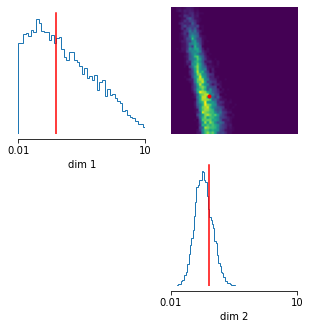

In [85]:
synthetic_obs = [simulator(true_params)['leaves'] for _ in range(20)]
x_o = summaries(synthetic_obs, synthetic_obs)

posterior = infer(all_sums_wrapper_iid(synthetic_obs), prior, method='SNPE', 
                  num_simulations=1000, num_workers=4)
samples = posterior.sample((10000,), 
                           x=x_o)
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


 Neural network successfully converged after 92 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

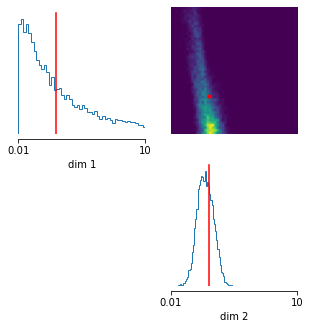

In [90]:
synthetic_obs = [simulator(true_params)['leaves'] for _ in range(20)]
x_o = summaries(synthetic_obs, synthetic_obs)

posterior = infer(all_sums_wrapper_iid(synthetic_obs), prior, method='SNPE', 
                  num_simulations=5000, num_workers=4)
samples = posterior.sample((10000,), 
                           x=x_o)
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [86]:
true_params = torch.tensor([3,3])
synthetic_obs = [simulator(true_params)['leaves'] for _ in range(20)]
x_o = summaries(synthetic_obs, synthetic_obs)
multi_simulator, prior = prepare_for_sbi(all_sums_wrapper_iid(synthetic_obs), prior)
inference = SNPE(prior=prior)
num_rounds = 10
posteriors = []
proposal = prior
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(multi_simulator, proposal, num_simulations=300)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 300 simulations.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 63 epochs.

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 60 epochs.

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

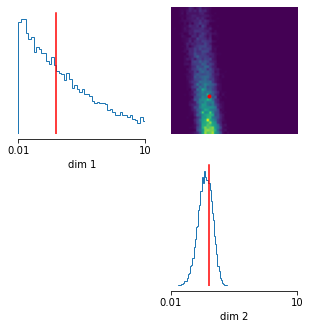

In [87]:
samples = posteriors[-1].sample((10000,), 
                           x=x_o)
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

# Sorted distances

In [121]:
def simulation_wrapper_iid_sorted(data):
    """
    Uses euclidean distances from a given observation as summary
    """
    def parameter_wrapper(params):
        distances = []
        current_obs = simulator(params)['leaves']
        for obs in data:
            if current_obs.isnan().any():
                distance = np.inf
            else:
                distance = sinkhorn_t(obs, current_obs)
            distances.append(distance)
        return torch.as_tensor([distances]).sort()[0]
    
    return parameter_wrapper

In [125]:
posterior = infer(simulation_wrapper_iid_sorted(synthetic_obs_multi), prior, method='SNPE', 
                  num_simulations=1000, num_workers=4)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 68 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

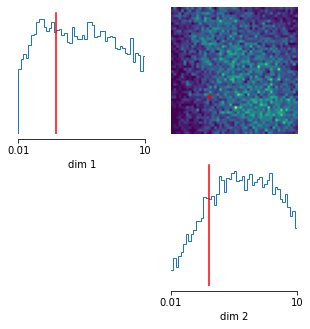

In [128]:
samples = posterior.sample((10000,), 
                           x=torch.zeros(50))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [130]:
posterior = infer(simulation_wrapper_iid(synthetic_obs_multi), prior, method='SNPE', 
                  num_simulations=1000, num_workers=4)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 72 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

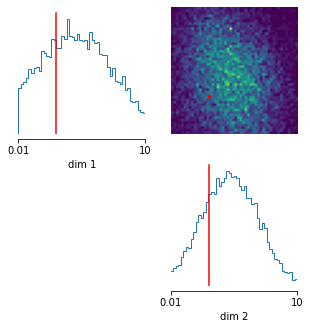

In [131]:
samples = posterior.sample((10000,), 
                           x=torch.zeros(50))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [132]:
posterior = infer(simulation_wrapper_iid_sum(synthetic_obs_multi), prior, method='SNPE', 
                  num_simulations=1000, num_workers=4)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 90 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

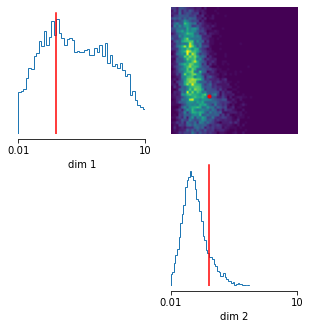

In [133]:
samples = posterior.sample((10000,), 
                           x=torch.zeros(1))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

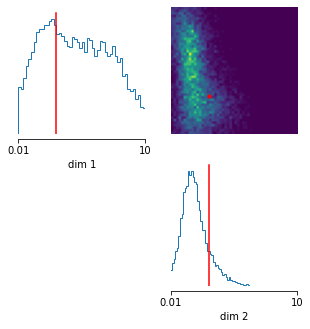

In [138]:
samples = posterior.sample((10000,), 
                           x=torch.tensor([30]))
fig, axes = analysis.pairplot(samples,
                           limits=[[.01,10.], [.01,10.]],
                           ticks=[[.01,10.], [.01,10.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');